KNN으로 전처리->모델링->평가

train							        test
1. 로지스틱 리그레션
정확도: 0.9321973730919417			    0.8637331440738112
재현율: 0.8321070234113712			    0.7112299465240641
정밀도: 0.9047272727272727			    0.76
F1 점수: 0.8668989547038327			    0.7348066298342542
Average Precision: 0.9497280415524426	0.7980369936650602
ROC-AUC Score: 0.9777947107253703		0.9232426567464931
tenure
numTechTickets
2. 랜덤포레스트
정확도: 0.9976925807596734			    0.8275372604684174
재현율: 0.9939799331103679			    0.5347593582887701
정밀도: 0.9973154362416108			    0.7434944237918215
F1 점수: 0.995644891122278			    0.6220839813374806
Average Precision: 0.9995315732169227	0.733095917078623
ROC-AUC Score: 0.9998261095816691		0.8978454622955901
numTechTickets_0
Contract_Month-to-month

3.디시전 트리
정확도: 0.938054668086617			    0.837473385379702
재현율: 0.8193979933110368			    0.6096256684491979
정밀도: 0.9394171779141104			    0.7331189710610932
F1 점수: 0.8753126116470168			    0.6656934306569343
Average Precision: 0.9504753518715865	0.6344248353840132
ROC-AUC Score: 0.9776862716262068		0.801331731638637
Contract_Month-to-month
numTechTickets_0

4.SVM
정확도: 0.8663385081408558			    0.8642816581487791
재현율: 0.7132667617689016			    0.708779443254818
정밀도: 0.7668711656441718			    0.7626728110599078
F1 점수: 0.7390983000739099			    0.7347391786903441
Average Precision: 0.8283109091431692	0.8222980379183387
ROC-AUC Score: 0.926338661999794		0.9221700220752014

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from metrics import print_binary_classification_metrics

df = pd.read_csv('../data/raw/Customer_Churn_Dataset_knn.csv', index_col=0)

In [6]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,0,0,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,0,No
2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,5,No
4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0,No


1. 원핫인코딩 후 logistic regression. y는 label-encoding

In [2]:
df_clone = df.copy(deep=False)

In [3]:
df_clone.shape

(7043, 22)

In [4]:
X = df_clone.drop(columns=["Churn"])
ohe = OneHotEncoder(sparse_output=False)
X = ohe.fit_transform(X)

column_names = ohe.get_feature_names_out()

le = LabelEncoder()
# y =df_clone['Churn']
y = le.fit_transform(df_clone['Churn'])
X.shape, y.shape




((7043, 8248), (7043,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ("model", LogisticRegression(random_state=0, C=1))
])

pipeline.fit(X_train, y_train)
# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

pred_train_proba = pipeline.predict_proba(X_train)
pred_test_proba = pipeline.predict_proba(X_test)


In [10]:

print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.9321973730919417
재현율: 0.8321070234113712
정밀도: 0.9047272727272727
F1 점수: 0.8668989547038327
Average Precision: 0.9497280415524426
ROC-AUC Score: 0.9777947107253703


In [11]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8637331440738112
재현율: 0.7112299465240641
정밀도: 0.76
F1 점수: 0.7348066298342542
Average Precision: 0.7980369936650602
ROC-AUC Score: 0.9232426567464931


In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty":['l1', 'l2']
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

c:\Users\82109\Documents\class\SKN21_2st_4team\SKN21-2nd-4Team\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
16 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\82109\Documents\class\SKN21_2st_4team\SKN21-2nd-4Team\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\82109\Documents\class\SKN21_2st_4team\SKN21-2nd-4Team\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *arg

,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__penalty': ['l1', 'l2']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [14]:
gs.best_score_

np.float64(0.8505479436173302)

In [15]:
gs.best_params_

{'model__C': 1, 'model__penalty': 'l2'}

In [16]:
import pandas as pd
df_gsresult = pd.DataFrame(gs.cv_results_)
df_gsresult.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
5,25.341733,1.421060,0.140096,0.042719,1.00,l2,"{'model__C': 1, 'model__penalty': 'l2'}",0.848829,0.865153,0.851562,0.836648,0.850548,0.010130,1
3,9.412669,1.002417,0.147690,0.030487,0.10,l2,"{'model__C': 0.1, 'model__penalty': 'l2'}",0.845990,0.856636,0.850142,0.828835,0.845401,0.010289,2
7,25.544697,0.598904,0.053708,0.012929,10.00,l2,"{'model__C': 10, 'model__penalty': 'l2'}",0.829666,0.855216,0.843040,0.830966,0.839722,0.010355,3
1,7.575533,0.413947,0.272793,0.150288,0.01,l2,"{'model__C': 0.01, 'model__penalty': 'l2'}",0.830376,0.830376,0.843040,0.811790,0.828895,0.011147,4
2,1.793798,0.729499,0.000000,0.000000,0.10,l1,"{'model__C': 0.1, 'model__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,5
0,1.948828,0.330945,0.000000,0.000000,0.01,l1,"{'model__C': 0.01, 'model__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,5
4,1.003154,0.106030,0.000000,0.000000,1.00,l1,"{'model__C': 1, 'model__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,5
6,1.340392,0.362756,0.000000,0.000000,10.00,l1,"{'model__C': 10, 'model__penalty': 'l1'}",NaN,NaN,NaN,NaN,NaN,NaN,5


In [17]:
# 평가
pred_train = gs.predict(X_train)
pred_test = gs.predict(X_test)

pred_train_proba = gs.predict_proba(X_train)
pred_test_proba = gs.predict_proba(X_test)

In [18]:
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.9321973730919417
재현율: 0.8321070234113712
정밀도: 0.9047272727272727
F1 점수: 0.8668989547038327
Average Precision: 0.9497280415524426
ROC-AUC Score: 0.9777947107253703


In [20]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8637331440738112
재현율: 0.7112299465240641
정밀도: 0.76
F1 점수: 0.7348066298342542
Average Precision: 0.7980369936650602
ROC-AUC Score: 0.9232426567464931


In [222]:
pipeline['model'].coef_

array([[-0.03701481, -0.15224596,  0.25115281, ...,  2.52647559,
         1.46704302,  0.        ]], shape=(1, 15291))

tenure_1            2.621005
numTechTickets_7    2.599052
tenure_2            1.915100
tenure_5            1.815984
numTechTickets_6    1.733769
                      ...   
numTechTickets_1   -1.504414
tenure_72          -1.517800
tenure_60          -1.553778
tenure_71          -1.570439
numTechTickets_0   -4.260985
Length: 8248, dtype: float64


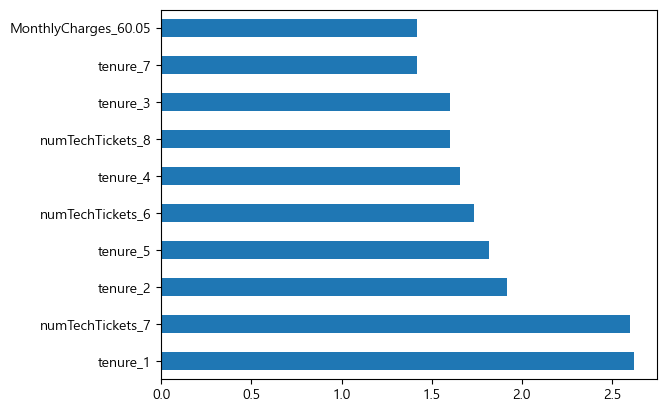

In [28]:
# 회귀 계수 확인
# coefficients = pipeline['model'].coef_[0] # 이진 분류의 경우, 첫 번째 클래스의 계수만 사용
coefficients = gs.best_estimator_['model'].coef_[0] # 이진 분류의 경우, 첫 번째 클래스의 계수만 사용

# 피처 이름과 계수 매핑
feature_names = column_names # 학습 시 사용한 피처 이름
coef_series = pd.Series(coefficients, index=feature_names)

# 결과 출력 (계수 값 기준 정렬 등)
print(coef_series.sort_values(ascending=False))

coef_series.sort_values(ascending=False)[:10].plot(kind="barh");


이 위까지 one-hot encoding 후 linear regression

2. Randomforest

In [30]:
df_clone = df.copy(deep=False)
X = df_clone.drop(columns=["Churn"])
ohe = OneHotEncoder(sparse_output=False)
X = ohe.fit_transform(X)
randomforest_feature_name = ohe.get_feature_names_out()
le = LabelEncoder()
# y =df_clone['Churn']
y = le.fit_transform(df_clone['Churn'])
X.shape, y.shape


((7043, 8248), (7043,))

In [21]:
X

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]], shape=(7043, 8248))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [32]:
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ("model", RandomForestClassifier(max_depth=16, random_state=42) )
])
# 랜덤 포레스트 모델 생성 및 학습
pipeline.fit(X_train, y_train)


,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_estimators,100
,criterion,'gini'
,max_depth,16
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'


In [33]:
# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

pred_train_proba = pipeline.predict_proba(X_train)
pred_test_proba = pipeline.predict_proba(X_test)

In [34]:
from metrics import print_binary_classification_metrics
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.8106141285055023
재현율: 0.2956521739130435
정밀도: 0.9692982456140351
F1 점수: 0.4531009738595592
Average Precision: 0.8503851086557976
ROC-AUC Score: 0.9319890494286746


In [35]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.7721788502484032
재현율: 0.1657754010695187
정밀도: 0.8732394366197183
F1 점수: 0.2786516853932584
Average Precision: 0.7201361361505793
ROC-AUC Score: 0.8841277222351392


In [40]:
from sklearn.model_selection import GridSearchCV

params = {
    # "model__max_depth": [4, 8, 16, 32, 64, 128],
    "model__max_depth": [40, 50, 60, 70],
    "model__n_estimators":[10, 50, 100, 200]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [40, 50, ...], 'model__n_estimators': [10, 50, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [42]:
print(gs.best_score_)
print(gs.best_params_)

0.8372384911929802
{'model__max_depth': 60, 'model__n_estimators': 200}


In [43]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [44]:
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.9976925807596734
재현율: 0.9939799331103679
정밀도: 0.9973154362416108
F1 점수: 0.995644891122278
Average Precision: 0.9995315732169227
ROC-AUC Score: 0.9998261095816691


In [45]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8275372604684174
재현율: 0.5347593582887701
정밀도: 0.7434944237918215
F1 점수: 0.6220839813374806
Average Precision: 0.733095917078623
ROC-AUC Score: 0.8978454622955901


In [46]:
gs.best_estimator_['model'].feature_importances_

array([0.00868154, 0.00865921, 0.00691019, ..., 0.00378906, 0.00089172,
       0.        ], shape=(8248,))

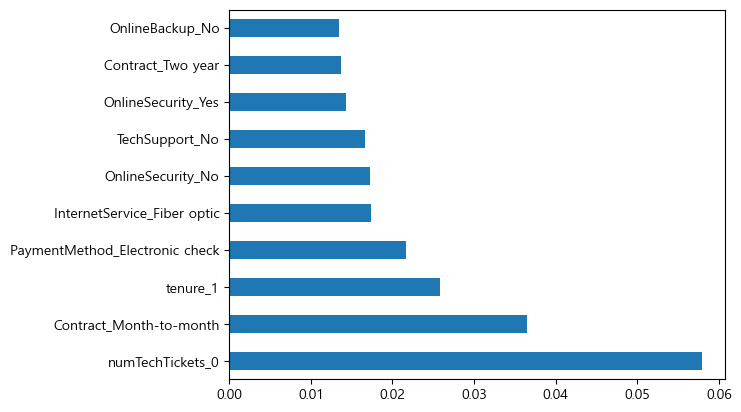

In [47]:
randomforest_feature_name[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=randomforest_feature_name).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");


여기까지 원핫인코딩 후 randomforest. y는 label

3. decision tree

In [8]:
df_clone = df.copy(deep=False)
X = df_clone.drop(columns=["Churn"])
ohe = OneHotEncoder(sparse_output=False)
X = ohe.fit_transform(X)
decision_feature_name = ohe.get_feature_names_out()
le = LabelEncoder()
# y =df_clone['Churn']
y = le.fit_transform(df_clone['Churn'])
X.shape, y.shape


((7043, 8248), (7043,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = Pipeline([
    ("model", DecisionTreeClassifier(max_depth=8, random_state=42) )
])
# 디시전 트리 모델 생성 및 학습
pipeline.fit(X_train, y_train)

,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,criterion,'gini'
,splitter,'best'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None


In [12]:
# 평가
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

pred_train_proba = pipeline.predict_proba(X_train)
pred_test_proba = pipeline.predict_proba(X_test)

In [13]:
from metrics import print_binary_classification_metrics
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.8659921902733404
재현율: 0.7311036789297659
정밀도: 0.7558782849239281
F1 점수: 0.7432845970758245
Average Precision: 0.8178847023102949
ROC-AUC Score: 0.9252507149142546


In [14]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8310858765081618
재현율: 0.6844919786096256
정밀도: 0.6808510638297872
F1 점수: 0.6826666666666666
Average Precision: 0.7054681301862438
ROC-AUC Score: 0.8624686765351728


In [15]:
from sklearn.model_selection import GridSearchCV

params = {
    "model__max_depth": [4, 8, 16, 32, 64]
}
gs = GridSearchCV(
    pipeline,
    params,
    scoring="accuracy", 
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [4, 8, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [16]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [17]:
from metrics import print_binary_classification_metrics
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.938054668086617
재현율: 0.8193979933110368
정밀도: 0.9394171779141104
F1 점수: 0.8753126116470168
Average Precision: 0.9504753518715865
ROC-AUC Score: 0.9776862716262068


In [18]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.837473385379702
재현율: 0.6096256684491979
정밀도: 0.7331189710610932
F1 점수: 0.6656934306569343
Average Precision: 0.6344248353840132
ROC-AUC Score: 0.801331731638637


In [19]:
print(gs.best_score_)
print(gs.best_params_)

0.8306714092441447
{'model__max_depth': 16}


In [56]:
import pandas as pd
df_gsresult = pd.DataFrame(gs.cv_results_)
df_gsresult.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,11.232899,0.928361,0.100749,0.007806,16,{'model__max_depth': 16},0.826828,0.831796,0.835227,0.828835,0.830671,0.003169,1
1,10.099567,0.565512,0.122727,0.006230,8,{'model__max_depth': 8},0.819021,0.836764,0.839489,0.824574,0.829962,0.008452,2
0,8.681439,0.590663,0.129874,0.015217,4,{'model__max_depth': 4},0.830376,0.823989,0.834517,0.817472,0.826588,0.006463,3
3,14.986897,0.593939,0.123831,0.046203,32,{'model__max_depth': 32},0.824698,0.827537,0.826705,0.818892,0.824458,0.003375,4
4,9.978128,0.961629,0.054414,0.015608,64,{'model__max_depth': 64},0.831086,0.830376,0.822443,0.811080,0.823746,0.008062,5


In [57]:
pipeline['model'].feature_importances_

array([0.00353581, 0.00207497, 0.        , ..., 0.00800261, 0.00263925,
       0.        ], shape=(8248,))

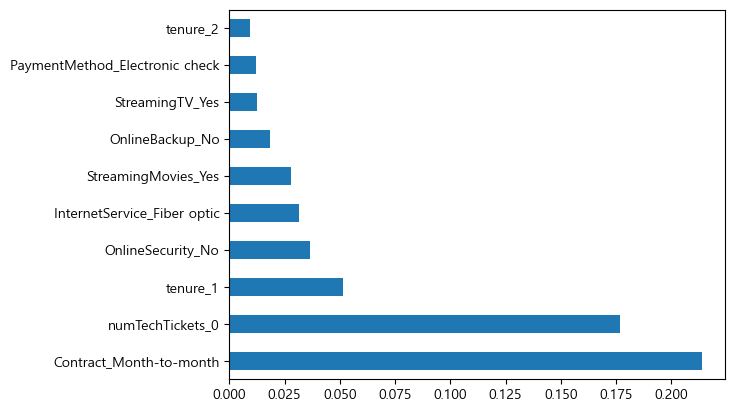

In [20]:
decision_feature_name[:-1]
best_model = gs.best_estimator_
fi = pd.Series(best_model['model'].feature_importances_, index=decision_feature_name).sort_values(ascending=False)
fi.sort_values(ascending=False)[:10].plot(kind="barh");

4. SVM

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df = pd.read_csv('../data/raw/Customer_Churn_Dataset_knn.csv', index_col=0)

In [25]:
df2 = df.copy()
df2 = df2.drop(columns='Churn')
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns
categorical_cols = df2.select_dtypes(include=['object']).columns
le = LabelEncoder()
y = le.fit_transform(df['Churn'])
ohe = OneHotEncoder(sparse_output=False)
cate_features = ohe.fit_transform(df2[categorical_cols])
X = np.concatenate(
    [cate_features, df2[numeric_cols].values], 
    axis=1
)
feature_names = np.concatenate(
    [ohe.get_feature_names_out(), numeric_cols],
    axis = 0
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# SVM : Feature scaling/One Hot Encoding 전처리.
pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("svm", SVC(random_state=0, probability=True)) # predict proba를 하기위해 probability=True가 필요
])

params = {
    # "svm__kernel": ["linear", "rbf",  "poly", "sigmoid"],
    "svm__C": [0.01, 0.1, 1, 10, 100], 
    "svm__gamma": [0.01, 0.1, 1, 10, 100], 
}

gs = GridSearchCV(
    pipeline, 
    params,
    scoring=["accuracy", "roc_auc", "average_precision"], 
    refit="accuracy",
    cv=4,
    n_jobs=-1
)
gs.fit(X_train, y_train)

,estimator,Pipeline(step...om_state=0))])
,param_grid,"{'svm__C': [0.01, 0.1, ...], 'svm__gamma': [0.01, 0.1, ...]}"
,scoring,"['accuracy', 'roc_auc', ...]"
,n_jobs,-1
,refit,'accuracy'
,cv,4
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [26]:
print(gs.best_score_, gs.best_params_)

0.8525171759227399 {'svm__C': 1, 'svm__gamma': 0.01}


In [27]:
gs.best_estimator_

,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1
,kernel,'rbf'
,degree,3
,gamma,0.01


In [28]:
# 평가
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [29]:
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.8663385081408558
재현율: 0.7132667617689016
정밀도: 0.7668711656441718
F1 점수: 0.7390983000739099
Average Precision: 0.8283109091431692
ROC-AUC Score: 0.926338661999794


In [30]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8642816581487791
재현율: 0.708779443254818
정밀도: 0.7626728110599078
F1 점수: 0.7347391786903441
Average Precision: 0.8222980379183387
ROC-AUC Score: 0.9221700220752014


In [7]:
import pandas as pd
pd.DataFrame(gs.cv_results_).sort_values("rank_test_accuracy")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svm__C,param_svm__gamma,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,split3_test_average_precision,mean_test_average_precision,std_test_average_precision,rank_test_average_precision
10,11.617058,0.945095,1.480123,0.098666,1.00,0.01,"{'svm__C': 1, 'svm__gamma': 0.01}",0.859198,0.850114,0.850758,...,0.912089,0.006914,1,0.820619,0.790952,0.784744,0.794922,0.797809,0.013660,1
15,11.034282,0.252150,1.666782,0.157358,10.00,0.01,"{'svm__C': 10, 'svm__gamma': 0.01}",0.859198,0.843301,0.852273,...,0.903783,0.007241,2,0.811338,0.776156,0.766501,0.799225,0.788305,0.017838,2
5,17.325074,0.892496,2.517304,0.727510,0.10,0.01,"{'svm__C': 0.1, 'svm__gamma': 0.01}",0.838759,0.838759,0.838636,...,0.899201,0.007581,3,0.781700,0.757852,0.739634,0.749172,0.757089,0.015601,4
20,14.728391,0.250995,1.530586,0.068496,100.00,0.01,"{'svm__C': 100, 'svm__gamma': 0.01}",0.848600,0.835731,0.825000,...,0.891071,0.008531,5,0.781586,0.758988,0.726914,0.772396,0.759971,0.020708,3
11,24.908563,1.655964,3.630662,0.161735,1.00,0.10,"{'svm__C': 1, 'svm__gamma': 0.1}",0.825889,0.823618,0.812879,...,0.854123,0.015966,6,0.735225,0.698053,0.659154,0.690408,0.695710,0.027071,6
16,29.670433,1.451168,3.040988,0.391692,10.00,0.10,"{'svm__C': 10, 'svm__gamma': 0.1}",0.806207,0.810749,0.808333,...,0.834166,0.014315,9,0.701448,0.655950,0.625159,0.649088,0.657911,0.027613,7
21,25.107416,1.171237,2.934952,0.050907,100.00,0.10,"{'svm__C': 100, 'svm__gamma': 0.1}",0.806964,0.810749,0.793939,...,0.813603,0.016676,10,0.637208,0.639840,0.583081,0.620864,0.620248,0.022657,10
6,28.225173,0.661649,4.638946,0.640313,0.10,0.10,"{'svm__C': 0.1, 'svm__gamma': 0.1}",0.775927,0.769114,0.767424,...,0.848742,0.012397,7,0.686107,0.647072,0.636668,0.606954,0.644200,0.028322,8
17,32.648962,0.596097,4.575643,0.137544,10.00,1.00,"{'svm__C': 10, 'svm__gamma': 1}",0.760030,0.755488,0.751515,...,0.720157,0.020754,15,0.537926,0.500351,0.490366,0.496128,0.506193,0.018661,14
12,31.570406,0.140796,4.307423,0.315363,1.00,1.00,"{'svm__C': 1, 'svm__gamma': 1}",0.757002,0.755488,0.753030,...,0.727105,0.027135,12,0.583050,0.518218,0.502850,0.508839,0.528239,0.032115,11


In [9]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    gs.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy'
)


numTechTickets  : 0.091 +/- 0.007
tenure          : 0.034 +/- 0.004
TotalCharges    : 0.025 +/- 0.003
InternetService_Fiber optic : 0.005 +/- 0.003
InternetService_DSL : 0.004 +/- 0.003
SeniorCitizen   : 0.002 +/- 0.001
Contract_Month-to-month : 0.002 +/- 0.002
MultipleLines_No : 0.001 +/- 0.002
PaymentMethod_Credit card (automatic) : 0.001 +/- 0.001
MonthlyCharges  : 0.001 +/- 0.002
MultipleLines_Yes : 0.001 +/- 0.001
StreamingTV_No  : 0.001 +/- 0.001
PaymentMethod_Mailed check : 0.001 +/- 0.001
StreamingMovies_No : 0.001 +/- 0.001
OnlineSecurity_No : 0.000 +/- 0.001
PhoneService_Yes : 0.000 +/- 0.001
PhoneService_No : 0.000 +/- 0.001
MultipleLines_No phone service : 0.000 +/- 0.001
StreamingMovies_Yes : 0.000 +/- 0.001
TechSupport_Yes : 0.000 +/- 0.002
StreamingTV_No internet service : 0.000 +/- 0.001
TechSupport_No internet service : 0.000 +/- 0.001
StreamingMovies_No internet service : 0.000 +/- 0.001
OnlineBackup_No internet service : 0.000 +/- 0.001
InternetService_No : 0.000 +/-

C:\Users\82109\AppData\Local\Temp\ipykernel_24084\1032942441.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])


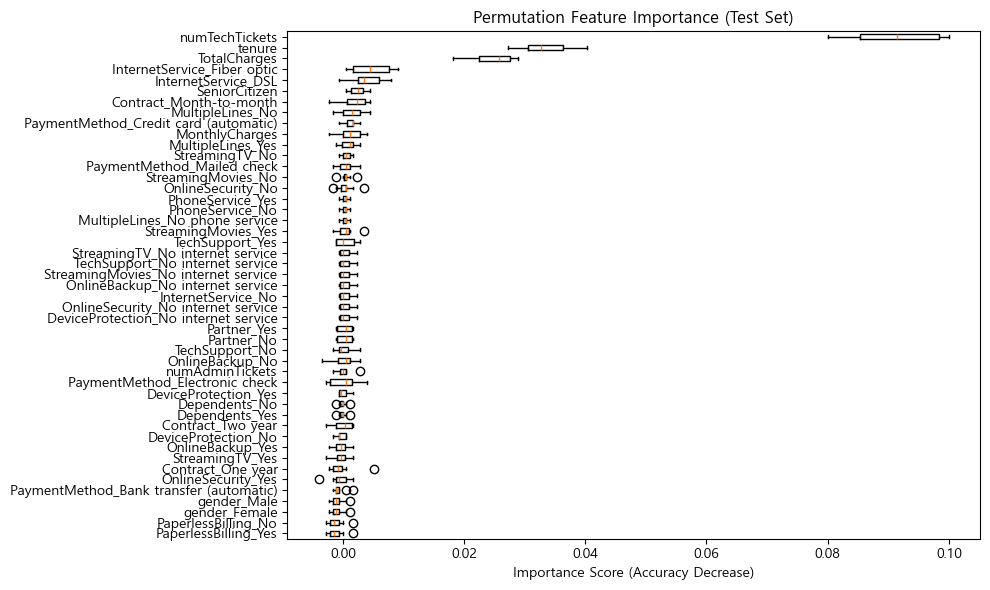

In [ ]:
sorted_idx = result.importances_mean.argsort()
for i in sorted_idx[::-1]: # 내림차순 출력
    print(f"{feature_names[i]:<15} : {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Feature Importance (Test Set)")
plt.xlabel("Importance Score (Accuracy Decrease)")
plt.tight_layout()
plt.show()


In [17]:
from metrics import print_binary_classification_metrics
pred_train = gs.best_estimator_.predict(X_train)
pred_test = gs.best_estimator_.predict(X_test)

pred_train_proba = gs.best_estimator_.predict_proba(X_train)
pred_test_proba = gs.best_estimator_.predict_proba(X_test)

In [18]:
print_binary_classification_metrics(y_train, pred_train, pred_train_proba[:, 1])

정확도: 0.8663385081408558
재현율: 0.7132667617689016
정밀도: 0.7668711656441718
F1 점수: 0.7390983000739099
Average Precision: 0.8283109091431692
ROC-AUC Score: 0.926338661999794


In [19]:
print_binary_classification_metrics(y_test, pred_test, pred_test_proba[:, 1])

정확도: 0.8642816581487791
재현율: 0.708779443254818
정밀도: 0.7626728110599078
F1 점수: 0.7347391786903441
Average Precision: 0.8222980379183387
ROC-AUC Score: 0.9221700220752014
